In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# functions

In [2]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

def plot_errors(plotcols, test_data, train_data):
    test_diff = test_data['outofsample_error']
    train_diff = train_data['insample_error']
    
    test_data['RMSE'] = test_diff.resample('D').apply(compute_RMSE).dropna()
    test_data['MAE'] = test_diff.resample('D').apply(compute_MAE).dropna()
    test_plot = test_data[plotcols].copy().drop_duplicates()
    
    train_data['RMSE'] = train_diff.resample('D').apply(compute_RMSE).dropna()
    train_data['MAE'] = train_diff.resample('D').apply(compute_MAE).dropna()
    train_plot = train_data[plotcols].copy().drop_duplicates()
    
    fig,axs = plt.subplots(len(plotcols),figsize=(10,10),sharex=True)
    for i,col in enumerate(plotcols):
        axs[i].plot(train_plot[col],color='green',label='in-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    for i,col in enumerate(plotcols):
        axs[i].plot(test_plot[col],color='purple',label='out-of-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    plt.show()

def retrain(old_train_data,old_test_data,train_to_date):
    new_train = pd.concat([old_train_data,old_test_data[old_test_data.index<=train_to_date]],ignore_index=False).dropna(how='any',axis=1).reset_index(drop=False)
    new_test = old_test_data[~old_test_data.index.isin(new_train['calculation_date'])].copy().reset_index(drop=False)
    arrs = trainer.get_train_test_arrays(new_train, new_test)
    train_X = arrs['train_X']
    train_y = arrs['train_y']
    test_X = arrs['test_X']
    test_y = arrs['test_y']
    preprocessor = trainer.preprocess()
    retrained_model = trainer.run_dnn(preprocessor,train_X,train_y)
    train_test = trainer.test_prediction_accuracy(new_train,new_test,retrained_model)
    new_test_data = train_test['test_data'].set_index('calculation_date')
    new_train_data = train_test['train_data'].set_index('calculation_date')
    print()
    plot_errors(plotcols,new_test_data,new_train_data)
    return new_train_data, new_test_data

# loading model

In [3]:
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
models = [f for f in os.listdir(models_dir) if f.find('ipynb')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_10_31 203810934918 tuned bloomberg barriers
1     2024_10_31 204451887463 tuned bloomberg asians


# loading data

0     2024_10_31 203810934918 tuned bloomberg barriers test_data.csv
1     2024_10_31 203810934918 tuned bloomberg barriers train_data.csv
2     2024_10_31 203810934918 tuned bloomberg barriers.pkl

spot price 
0        676.03
1        682.43
2        683.09
3        696.44
4        701.13
         ...   
1095    1461.17
1096    1461.21
1097    1461.31
1098    1461.36
1099    1465.27
Name: spot_price, Length: 1100, dtype: float64

strike price 
0        608.42700
1        614.18700
2        614.78100
3        625.32775
4        626.79600
           ...    
9885    1607.28700
9886    1607.33100
9887    1607.44100
9888    1607.49600
9889    1611.79700
Name: strike_price, Length: 9890, dtype: float64

days to maturity 
0     60
1     90
2    180
3    360
4    540
5    720
Name: days_to_maturity, dtype: int64

risk free rate 
0    0.04
Name: risk_free_rate, dtype: float64

dividend rate 
0       0.017912
1       0.017942
2       0.017970
3       0.017981
4       0.017985
          ...   
1

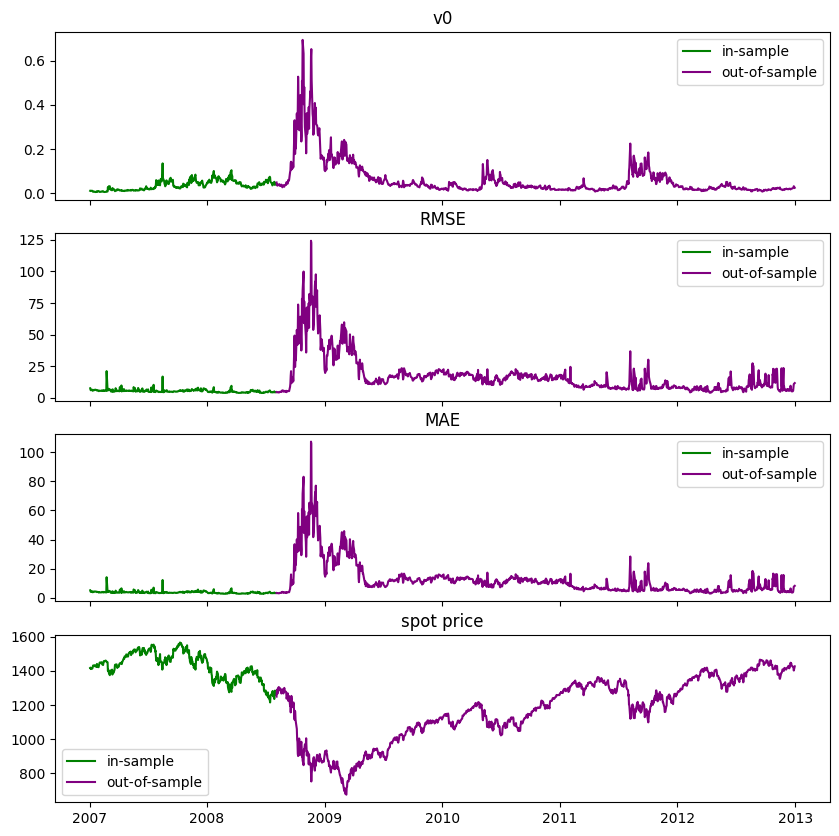

In [4]:
"""
select model here
"""
model = models[0]
""""""

plotcols = ['v0','RMSE', 'MAE','spot_price']

from convsklearn import asian_trainer, barrier_trainer

model_dir = os.path.join(models_dir,model)
model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1 and f.find('.html')==-1]
for i,m in enumerate(model_files):
    print(f"{i}     {m}")
print()
if any('asian' in file for file in model_files):
    trainer = asian_trainer
if any('barrier' in file for file in model_files):
    trainer = barrier_trainer

train_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f.find('train')!=-1][0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f. find('test')!=-1][0])).iloc[:,1:].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'])
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'])
train_data = train_data.set_index('calculation_date')
test_data = test_data.set_index('calculation_date')
test_dates = pd.Series(test_data.index).sort_values(ascending=True).drop_duplicates().reset_index(drop=True)
model_fit = joblib.load(os.path.join(model_dir,[f for f in model_files if f.endswith('.pkl')][0]))

for col in trainer.feature_set:
    print(f"{col.replace("_"," "):}",f"\n{test_data[col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()
print(model_fit)

plot_errors(plotcols, test_data, train_data)

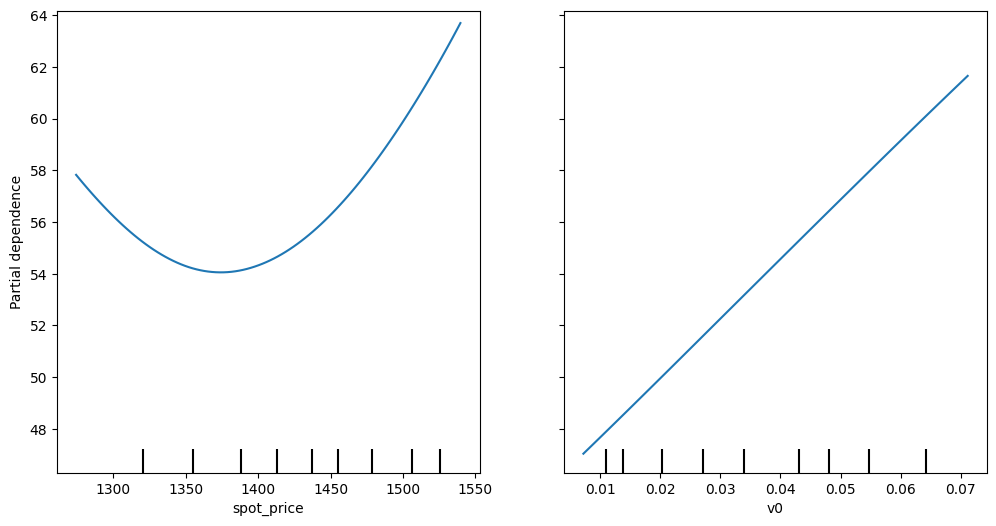

In [5]:
from sklearn.inspection import partial_dependence,PartialDependenceDisplay

part_disp_X = train_data[model_fit.feature_names_in_]
fig, ax = plt.subplots(figsize=(12, 6))
disp = PartialDependenceDisplay.from_estimator(model_fit, part_disp_X, ['spot_price','v0'], ax=ax)

# retraining

In [6]:
retraining_frequency = 100  # days
retraining_i = np.arange(retraining_frequency,len(test_dates),retraining_frequency)
retraining_dates = test_dates[retraining_i].reset_index(drop=True)
print(retraining_dates)

0    2008-12-24
1    2009-05-20
2    2009-10-12
3    2010-03-08
4    2010-07-29
5    2010-12-20
6    2011-05-13
7    2011-10-05
8    2012-02-29
9    2012-07-23
10   2012-12-14
Name: calculation_date, dtype: datetime64[ns]


In [ ]:
for date in retraining_dates:
    print()
    print(date.strftime('%c'))
    retrain(train_data,test_data,date)
    print()


Wed Dec 24 00:00:00 2008

training...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
